## Problem Statement_[Data Science for Good: Kiva Crowdfunding](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding)
Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. For the locations in which Kiva has active loans, your objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.

A good solution would connect the features of each loan or product to one of several poverty mapping datasets, which indicate the average level of welfare in a region on as granular a level as possible. Many datasets indicate the poverty rate in a given area, with varying levels of granularity. Kiva would like to be able to disaggregate these regional averages by gender, sector, or borrowing behavior in order to estimate a Kiva borrower’s level of welfare using all of the relevant information about them. Strong submissions will attempt to map vaguely described locations to more accurate geocodes.

Kernels submitted will be evaluated based on the following criteria:

1. Localization - How well does a submission account for highly localized borrower situations? Leveraging a variety of external datasets and successfully building them into a single submission will be crucial.

2. Execution - Submissions should be efficiently built and clearly explained so that Kiva’s team can readily employ them in their impact calculations.

3. Ingenuity - While there are many best practices to learn from in the field, there is no one way of using data to assess welfare levels. It’s a challenging, nuanced field and participants should experiment with new methods and diverse datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

## Original Data From Kaggle

### The loans

In [2]:
loans = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/kiva_loans.csv')

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

In [4]:
loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


#### `funded_amout` v.s. `the loan_amout`

* `funded_amount`: The amount disbursed by Kiva to the field agent(USD)

* `loan_amount`: The amount disbursed by the field agent to the borrower(USD)

In [5]:
(loans.funded_amount == loans.loan_amount).value_counts()

True     622875
False     48330
dtype: int64

In [6]:
48330/622875

0.07759181216134858

In [7]:
loans[loans.funded_amount != loans.loan_amount].head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
87,653261,4275.0,5000.0,Personal Housing Expenses,Housing,"to pave the ground and repair the ceiling, to ...",PS,Palestine,jenin,USD,122.0,2014-01-02 09:53:45+00:00,2013-12-24 08:00:00+00:00,NaN,39.0,58,"#Supporting Family, #Interesting Photo, user_f...",male,monthly,2014-01-02
112,653256,1925.0,2400.0,Electronics Repair,Services,to pay the annual rent for his shop,IQ,Iraq,NaN,USD,166.0,2014-01-02 09:44:10+00:00,2013-12-29 08:00:00+00:00,NaN,15.0,41,"#Single, #Supporting Family, #Eco-friendly, us...",male,monthly,2014-01-02
186,653253,2625.0,3000.0,Grocery Store,Food,to pay the annual rent on his grocery store an...,IQ,Iraq,NaN,USD,166.0,2014-01-02 09:35:12+00:00,2013-12-29 08:00:00+00:00,NaN,15.0,72,"#First Loan, #Biz Durable Asset, #Single, user...",male,monthly,2014-01-02
309,653259,2750.0,3000.0,Grocery Store,Food,to install a new floor in his grocery store an...,IQ,Iraq,NaN,USD,166.0,2014-01-02 09:51:47+00:00,2013-12-30 08:00:00+00:00,NaN,15.0,44,"#Biz Durable Asset, #Supporting Family, user_f...",male,monthly,2014-01-02
313,653263,1300.0,3000.0,Clothing,Clothing,to buy shoes and clothes to sell.,PS,Palestine,jenin,USD,122.0,2014-01-02 10:03:18+00:00,2013-12-24 08:00:00+00:00,NaN,27.0,35,"#Parent, user_favorite",female,monthly,2014-01-02


For about 8% of the cases, the funded amount is not equal to the loan amount.

In [8]:
(loans.funded_amount > loans.loan_amount).sum()

2

In [9]:
loans[(loans.funded_amount > loans.loan_amount)]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
277188,924149,425.0,400.0,General Store,Retail,"to buy beverages, rice, laundry detergent, sug...",MZ,Mozambique,"Boane, Maputo",MZN,23.0,2015-07-28 07:14:04+00:00,2015-07-22 07:00:00+00:00,NaN,17.0,11,"#Parent, user_favorite",male,monthly,2015-07-28
338159,985199,3400.0,3000.0,Farm Supplies,Agriculture,"to pay for wires for the grape orchard, cover ...",AM,Armenia,"Hoktember village, Armavir region",USD,169.0,2015-11-25 10:53:00+00:00,2015-10-29 07:00:00+00:00,NaN,38.0,84,"#Elderly, #Job Creator, #Trees, #Vegan, user_f...",male,monthly,2015-11-25


There are only two cases where the loan got more fund.

#### `sector` ,  `activity`, and `use`
* `sector`: High level category
* `activity`: More granular category

* <span class="burk">`use`: Exact usage of loan amount</span>

In [10]:
loans.sector.value_counts()

Agriculture       180302
Food              136657
Retail            124494
Services           45140
Personal Use       36385
Housing            33731
Clothing           32742
Education          31013
Transportation     15518
Arts               12060
Health              9223
Construction        6268
Manufacturing       6208
Entertainment        830
Wholesale            634
Name: sector, dtype: int64

The main sectors are Agriculture, Food and Retail

In [11]:
main_sectors = ['Agriculture', 'Food', 'Retail']
for sector in main_sectors:
    print('Activity in {}:\n'.format(sector), loans[loans.sector == sector].activity.value_counts())
    print('\n')

Activity in Agriculture:
 Farming             72955
Agriculture         27023
Pigs                26624
Livestock           13095
Poultry              9783
Animal Sales         9237
Dairy                7914
Cattle               7865
Farm Supplies        4352
Flowers               821
Land Rental           277
Veterinary Sales      198
Aquaculture           108
Beekeeping             50
Name: activity, dtype: int64


Activity in Food:
 Food Production/Sales         28106
Fruits & Vegetables           16610
Grocery Store                 15102
Fish Selling                  13060
Food                          10197
Fishing                       10066
Food Stall                     8905
Cereals                        7898
Food Market                    7091
Restaurant                     4981
Bakery                         3620
Beverages                      2357
Butcher Shop                   1968
Milk Sales                     1771
Liquor Store / Off-License     1558
Cafe                

#### `country_code`, `country` and  `region`: will be used for merging and grouping
* `country_code`: ISO country code of country in which loan was disbursed

* `country`: Full country name of country in which loan was disbursed

* `region`: Full region name within the country

There are some null value in country_code and region

In [12]:
loans.country_code.isnull().sum()

8

In [13]:
loans[loans.country_code.isna()][['country_code','country']]

,country_code,country
202537,NaN,Namibia
202823,NaN,Namibia
344929,NaN,Namibia
351177,NaN,Namibia
420953,NaN,Namibia
421218,NaN,Namibia
487207,NaN,Namibia
487653,NaN,Namibia


All missing values of country_code come from Namibia whose ISO code is NA([countrycode.org](https://countrycode.org/))

In [14]:
loans.country_code.fillna('NA', inplace=True)

In [15]:
loans.country_code.isnull().sum()

0

In the `loans` dataset, the type of `country_code` is ISO 3166-1 alpha-2 code, which is a two-letter code representing countries. However, in the `mpi_region_locations` and `loan_themes_by_region` datasets, the type of `ISO` is ISO 3166-1 alpha-3 code, which is a three-letter code representing the same countries with ISO 3166-1 alpha-2 code.

Here, they will be aligned to the same code type, ISO 3166-1 alpha-3.

In [16]:
ISO_country_code = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/wikipedia-iso-country-codes.csv')

In [17]:
ISO_country_code.head()

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [18]:
ISO_country_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   English short name lower case  246 non-null    object
 1   Alpha-2 code                   245 non-null    object
 2   Alpha-3 code                   246 non-null    object
 3   Numeric code                   246 non-null    int64 
 4   ISO 3166-2                     246 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.7+ KB


In [19]:
ISO_2_3 = ISO_country_code.iloc[:, 0:3]

In [20]:
ISO_2_3.rename({'English short name lower case':'country', 'Alpha-2 code':'country_code', 'Alpha-3 code':'ISO'}, axis=1, inplace=True)

In [21]:
ISO_2_3.head()

,country,country_code,ISO
0,Afghanistan,AF,AFG
1,Åland Islands,AX,ALA
2,Albania,AL,ALB
3,Algeria,DZ,DZA
4,American Samoa,AS,ASM


In [22]:
loans_ISO_2_3 = pd.merge(loans, ISO_2_3, on=['country','country_code'], how='left')

To check the result

In [23]:
len(loans_ISO_2_3.country.unique())

87

In [24]:
len(loans_ISO_2_3.country_code.unique())

87

In [25]:
len(loans_ISO_2_3.ISO.unique())

77

In [26]:
loans_ISO_2_3.ISO.isnull().sum()

26360

In [27]:
loans[loans_ISO_2_3.ISO.isnull()].country.unique()

array(['Tanzania', 'Palestine', 'United States', 'Kosovo',
       'The Democratic Republic of the Congo', 'Virgin Islands',
       'Myanmar (Burma)', 'Moldova', 'South Sudan', 'Namibia',
       "Cote D'Ivoire"], dtype=object)

There is inconsistency of countries' name between two datasets, so merging will be done only on `country_code`

In [28]:
ISO_2_3_revised = ISO_2_3.iloc[:,1:]

In [29]:
loans_ISO_2_3_revised = pd.merge(loans, ISO_2_3_revised, on='country_code', how='left')

In [30]:
loans_ISO_2_3_revised.ISO.isnull().sum()

1587

There are still Nan values in `ISO`.

In [31]:
loans[loans_ISO_2_3_revised.ISO.isnull()].country_code.unique()

array(['XK', 'SS', 'NA'], dtype=object)

In [32]:
loans[loans.country_code=='XK'].country.unique()

array(['Kosovo'], dtype=object)

In [33]:
loans[loans.country_code=='SS'].country.unique()

array(['South Sudan'], dtype=object)

According to [countrycode.org](https://countrycode.org/), the 3-digit ISO code of Kosovo, whose 2-digit code is 'XK', is 'XKX'; the 3-digit ISO code of South Sudan, whose 2-digit code is 'SS', is 'SSD'.

In [34]:
d = {'XK': "XKX", 'SS':'SSD'}
s = loans_ISO_2_3_revised.country_code.map(d)

loans_ISO_2_3_revised.ISO = loans_ISO_2_3_revised.ISO.combine_first(s)
loans_ISO_2_3_revised.ISO.isnull().sum()

8

In [35]:
loans_ISO = loans.drop('country_code', axis=1)
loans_ISO['ISO'] = loans_ISO_2_3_revised.ISO

In [36]:
loans_ISO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country             671205 non-null  object 
 7   region              614405 non-null  object 
 8   currency            671205 non-null  object 
 9   partner_id          657698 non-null  float64
 10  posted_time         671205 non-null  object 
 11  disbursed_time      668809 non-null  object 
 12  funded_time         622874 non-null  object 
 13  term_in_months      671205 non-null  float64
 14  lender_count        671205 non-null  int64  
 15  tags                499789 non-nul

Now, `country_code` column has been removed and `ISO` factor is added without missing values

In [37]:
loans[loans.region.isnull()]['country'].value_counts()

El Salvador      20251
Kenya             8752
Rwanda            6138
United States     5173
Senegal           3231
                 ...  
Bhutan               1
China                1
Kyrgyzstan           1
Guam                 1
Georgia              1
Name: country, Length: 72, dtype: int64

<span class="burk">The 58000 entries having no region information involves 72 countries.</span>

#### <span class="burk">`curreny` and `partner_id`</span> 
* `currency`: The currency in which the loan was disbursed

* `partner_id`: ID of partner organization

#### <span class="burk">`posted_time`, `disbursed_time`, `funded_time` and `date`: timezone issue</span>
* `posted_time`: The time at which the loan is posted on Kiva by the field agent

* `disbursed_time`: The time at which the loan is disbursed by the field agent to the borrower

* `funded_time`: The time at which the loan posted to Kiva gets funded by lenders completely

* `date`: No descprition.

In [38]:
times = loans[['posted_time', 'disbursed_time', 'funded_time', 'date']]

In [39]:
times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   posted_time     671205 non-null  object
 1   disbursed_time  668809 non-null  object
 2   funded_time     622874 non-null  object
 3   date            671205 non-null  object
dtypes: object(4)
memory usage: 20.5+ MB


In [40]:
times.head()

,posted_time,disbursed_time,funded_time,date
0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,2014-01-01
1,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,2014-01-01
2,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,2014-01-01
3,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,2014-01-01
4,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,2014-01-01


In [41]:
# Keep the date only
times = times.apply(lambda x: x.str[:10])

In [42]:
times

,posted_time,disbursed_time,funded_time,date
0,2014-01-01,2013-12-17,2014-01-02,2014-01-01
1,2014-01-01,2013-12-17,2014-01-02,2014-01-01
2,2014-01-01,2013-12-17,2014-01-01,2014-01-01
3,2014-01-01,2013-12-24,2014-01-01,2014-01-01
4,2014-01-01,2013-12-17,2014-01-01,2014-01-01
...,...,...,...,...
671200,2017-07-25,2017-07-25,NaN,2017-07-25
671201,2017-07-25,2017-07-24,2017-07-26,2017-07-25
671202,2017-07-26,2017-07-25,NaN,2017-07-26
671203,2017-07-26,2017-07-25,NaN,2017-07-26


* `posted_time` and `date`

In [43]:
(times.posted_time != times.date).sum()

0

The dates of `posted_time` and `date` are the same, both of which have no null value.

* `disbursed_time` and `funded_time`

In [44]:
(times.disbursed_time.isnull()).sum()

2396

In [45]:
loans[times.disbursed_time.isnull()]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
2221,1080194,30.0,4500.0,Clothing,Clothing,increase the inventory of my online clothing b...,US,United States,NaN,USD,NaN,2014-01-08 22:40:15+00:00,NaN,NaN,24.0,2,NaN,female,bullet,2014-01-08
2514,1080215,50.0,2500.0,Crafts,Arts,start a new photography business by providing ...,US,United States,NaN,USD,NaN,2014-01-09 23:55:12+00:00,NaN,NaN,13.0,2,NaN,male,bullet,2014-01-09
3065,1080225,10.0,5000.0,Services,Services,help my partner and I couch women in the fashi...,US,United States,NaN,USD,NaN,2014-01-10 17:22:31+00:00,NaN,NaN,30.0,1,NaN,female,bullet,2014-01-10
3072,1080216,755.0,10000.0,Services,Services,NaN,US,United States,NaN,USD,NaN,2014-01-10 00:18:32+00:00,NaN,NaN,24.0,55,NaN,NaN,bullet,2014-01-10
3847,1080244,125.0,125.0,Services,Services,NaN,KE,Kenya,NaN,KES,NaN,2014-01-14 08:13:48+00:00,NaN,2014-01-23 13:38:53+00:00,2.0,6,NaN,NaN,bullet,2014-01-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670825,1337741,0.0,2000.0,Cleaning Services,Services,me purchase a new commercial vacuum cleaner an...,US,United States,NaN,USD,NaN,2017-07-11 00:00:00+00:00,NaN,NaN,18.0,0,NaN,female,bullet,2017-07-11
670833,1337927,500.0,10000.0,Retail,Retail,me remodel and expand my new storefront.,US,United States,NaN,USD,NaN,2017-07-11 00:00:00+00:00,NaN,NaN,36.0,9,NaN,female,bullet,2017-07-11
670883,1337787,1350.0,2000.0,Grocery Store,Food,"me to to buy more fruit, prep materials and pu...",US,United States,NaN,USD,NaN,2017-07-11 00:00:00+00:00,NaN,NaN,18.0,21,"user_favorite, user_favorite, user_favorite, #...",male,bullet,2017-07-11
670914,1337780,1000.0,7000.0,Arts,Arts,"us get a U.S. patent, and update our website &...",US,United States,NaN,USD,NaN,2017-07-11 00:00:00+00:00,NaN,NaN,36.0,7,NaN,female,bullet,2017-07-11


In [46]:
loans[times.disbursed_time.isnull()].country_code.value_counts()

US    1995
KE     381
PR      17
VI       2
GU       1
Name: country_code, dtype: int64

In [47]:
loans[loans.country_code == 'US'].country_code.count()

6093

In [48]:
1995 / 6093

0.327424913835549

About one-third of loans disbursed in the United States has no information of the disbursed time, which accounts for the majority of the all countries losing this info.

In [49]:
posted_nan_disbursed = times[times.disbursed_time.isnull()].posted_time
posted_nan_disbursed = posted_nan_disbursed.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

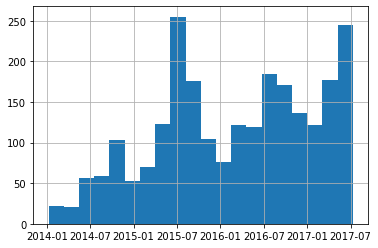

In [50]:
_ = posted_nan_disbursed.hist(bins=20)

It seems that the loans which were posted around the middle of the year tend to lose disbursed time info

In [51]:
(times.funded_time.isnull()).sum()

48331

In [52]:
posted_nan_funded = times[times.funded_time.isnull()].posted_time
posted_nan_funded = posted_nan_funded.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

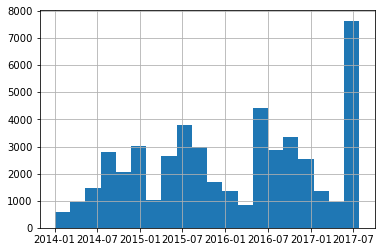

In [53]:
_ = posted_nan_funded.hist(bins=20)

The loans posted in the last month of the dataset, 2017-7, tended to lost funded time info.

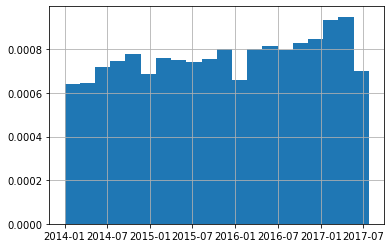

In [54]:
posted = times.posted_time.apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
_ = posted.hist(bins=20, density=True)

During the time period of the dataset, the loans posted on the platform were distributed evenly.

<div class="burk">
Check more about the patterns of the null value of disbursed time and funded time</div><i class="fa fa-lightbulb-o "></i>

#### `term_in_months` ,  `lender_count` and `repayment_interval` : No missing values
* `term_in_months`: The duration for which the loan was disbursed in months

* `lender_count`: The total number of lenders that contributed to this loan

* `repayment_interval`: No description

In [55]:
loans.term_in_months.describe()

count    671205.000000
mean         13.739022
std           8.598919
min           1.000000
25%           8.000000
50%          13.000000
75%          14.000000
max         158.000000
Name: term_in_months, dtype: float64

In [56]:
loans.lender_count.describe()

count    671205.000000
mean         20.590922
std          28.459551
min           0.000000
25%           7.000000
50%          13.000000
75%          24.000000
max        2986.000000
Name: lender_count, dtype: float64

In [57]:
loans.repayment_interval.value_counts()

monthly      342717
irregular    257158
bullet        70728
weekly          602
Name: repayment_interval, dtype: int64

#### `borrower_genders`
* `borrower_genders`: Comma separated M,F letters, where each instance represents a single male/female in the group

In [58]:
loans.borrower_genders.isna().sum()

4221

In [59]:
loans[loans.borrower_genders.isna()]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
140,653375,2975.0,2975.0,Food Production/Sales,Food,NaN,TZ,Tanzania,NaN,TZS,87.0,2014-01-02 15:31:52+00:00,2013-12-24 08:00:00+00:00,2014-01-22 13:42:40+00:00,10.0,110,user_favorite,NaN,monthly,2014-01-02
145,653427,1200.0,1200.0,Personal Expenses,Personal Use,NaN,PE,Peru,NaN,PEN,139.0,2014-01-02 22:43:24+00:00,2013-12-17 08:00:00+00:00,2014-02-01 23:49:27+00:00,20.0,44,"#Single, user_favorite, user_favorite",NaN,monthly,2014-01-02
170,653177,4250.0,4250.0,Catering,Food,NaN,TZ,Tanzania,NaN,TZS,87.0,2014-01-02 06:46:10+00:00,2013-12-26 08:00:00+00:00,2014-01-23 16:52:15+00:00,10.0,116,"#Schooling, #Repeat Borrower, #Woman Owned Biz...",NaN,monthly,2014-01-02
412,653513,2350.0,2350.0,Beauty Salon,Services,NaN,TZ,Tanzania,NaN,TZS,87.0,2014-01-03 05:08:11+00:00,2013-12-31 08:00:00+00:00,2014-01-21 15:33:01+00:00,10.0,75,"user_favorite, #Parent, #Woman Owned Biz, user...",NaN,monthly,2014-01-03
414,653775,725.0,725.0,Agriculture,Agriculture,NaN,SV,El Salvador,NaN,USD,199.0,2014-01-03 21:41:23+00:00,2013-12-16 08:00:00+00:00,2014-01-28 17:28:43+00:00,20.0,19,"#Animals, #Repeat Borrower, #Schooling, user_f...",NaN,monthly,2014-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671151,1340245,0.0,25.0,Livestock,Agriculture,NaN,KE,Kenya,NaN,KES,138.0,2017-07-20 23:13:01+00:00,2017-07-20 07:00:00+00:00,NaN,13.0,0,NaN,NaN,monthly,2017-07-20
671174,1340275,0.0,25.0,Games,Entertainment,NaN,KE,Kenya,NaN,KES,138.0,2017-07-21 23:51:18+00:00,2017-07-21 07:00:00+00:00,NaN,13.0,0,NaN,NaN,monthly,2017-07-21
671178,1340280,0.0,25.0,Livestock,Agriculture,NaN,KE,Kenya,NaN,KES,138.0,2017-07-22 06:16:55+00:00,2017-07-21 07:00:00+00:00,NaN,13.0,0,NaN,NaN,monthly,2017-07-22
671185,1340298,0.0,25.0,Livestock,Agriculture,NaN,KE,Kenya,NaN,KES,138.0,2017-07-24 07:34:50+00:00,2017-07-17 07:00:00+00:00,NaN,13.0,0,NaN,NaN,monthly,2017-07-24


<div class="burk">
Check more about the patterns of the null value of the borrowers' gender</div><i class="fa fa-lightbulb-o "></i>

In [60]:
loans.borrower_genders.value_counts()

female                                                                                                                                                                                                                                                          426502
male                                                                                                                                                                                                                                                            134710
female, female                                                                                                                                                                                                                                                   12164
female, female, female                                                                                                                                                                                             

In [61]:
loans.borrower_genders.value_counts().head(10)

female                                                                            426502
male                                                                              134710
female, female                                                                     12164
female, female, female                                                             11676
female, female, female, female                                                      9052
female, female, female, female, female                                              7568
female, female, female, female, female, female                                      2674
female, female, female, female, female, female, female, female, female, female      2185
female, female, female, female, female, female, female                              2127
female, female, female, female, female, female, female, female                      1936
Name: borrower_genders, dtype: int64

Female borrowers make up the majority

#### `tags`

In [62]:
loans.tags.isna().sum()

171416

In [63]:
loans.tags.value_counts()

user_favorite                                                                                                                           27088
#Parent, #Woman Owned Biz                                                                                                               16597
#Woman Owned Biz                                                                                                                        12557
#Parent                                                                                                                                 11671
#Elderly                                                                                                                                 6482
                                                                                                                                        ...  
user_favorite, user_favorite, #Animals, #Biz Durable Asset, #Parent, #Sustainable Ag, #Woman Owned Biz, user_favorite, user_favorite        1
#Repea

In [64]:
loans.tags.value_counts().head(10)

user_favorite                                         27088
#Parent, #Woman Owned Biz                             16597
#Woman Owned Biz                                      12557
#Parent                                               11671
#Elderly                                               6482
#Eco-friendly, #Health and Sanitation, #Technology     5887
#Animals                                               5610
user_favorite, user_favorite                           5594
#Repeat Borrower                                       4627
#Woman Owned Biz, #Parent                              4305
Name: tags, dtype: int64

There are some duplicate tags such as `user_favorite` and `user_favorite, user_favorite`, `#Parent, #Woman Owned Biz` and `#Woman Owned Biz, #Parent`

### MPI by the location of region

In [65]:
mpi_region_locations = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/kiva_mpi_region_locations.csv')

In [66]:
mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LocationName  984 non-null    object 
 1   ISO           1008 non-null   object 
 2   country       1008 non-null   object 
 3   region        984 non-null    object 
 4   world_region  1008 non-null   object 
 5   MPI           984 non-null    float64
 6   geo           2772 non-null   object 
 7   lat           892 non-null    float64
 8   lon           892 non-null    float64
dtypes: float64(3), object(6)
memory usage: 195.0+ KB


Column descriptions:

0. LocationName: region, country

1. ISO: some sort of unique abbreviation for country
2. country

3. region
4. world_region: parts of the world
5. MPI: multidimensional poverty index
6. geo: (latitude, longitude)
7. lat
8. lon

In [67]:
mpi_region_locations.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


### Loan themes

In [68]:
loan_theme_ids = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/loan_theme_ids.csv')

In [69]:
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               779092 non-null  int64  
 1   Loan Theme ID    764279 non-null  object 
 2   Loan Theme Type  764279 non-null  object 
 3   Partner ID       764279 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


Column descriptions:

0. id:

1. Loan Theme ID: Unique ID for loan theme

2. Loan Theme Type: General description of the loan theme category

3. Partner ID: Unique ID for field partners


In [70]:
loan_theme_ids.head(20)

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0
5,642256,a1050000000T3oX,Extreme Poverty,217.0
6,642311,a1050000000snTK,General,57.0
7,642353,a1050000000T3oX,Extreme Poverty,217.0
8,642386,a1050000000wf0f,General,133.0
9,642429,a1050000000wezJ,General,48.0


It seems that `Loan Theme ID` is unique to the pair of `Loan Theme Type` and `Partner ID`. For example, for the pair of 'General'(`Loan Theme Type`) and '151'(`Partner ID`), `Loan Theme ID` is 'a1050000000skGl', while for the pair of 'General'(`Loan Theme Type`) and '57'(`Partner ID`), `Loan Theme ID` is 'a1050000000snTK'.

<span class="burk">Unique id for loans is 779092 in the `loan_theme_ids` dataset, while it is 671205 in the `loans` dataset. In other words， the 100,000 entries without the detailed loan information can be used for the loan-theme-type analysis but might be dropped when doing modeling.</span>

### Loan themes by region

In [74]:
loan_themes_by_region = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/KivaData/loan_themes_by_region.csv')

In [75]:
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Partner ID          15736 non-null  int64  
 1   Field Partner Name  15736 non-null  object 
 2   sector              15736 non-null  object 
 3   Loan Theme ID       15736 non-null  object 
 4   Loan Theme Type     15736 non-null  object 
 5   country             15736 non-null  object 
 6   forkiva             15736 non-null  object 
 7   region              15736 non-null  object 
 8   geocode_old         1200 non-null   object 
 9   ISO                 15722 non-null  object 
 10  number              15736 non-null  int64  
 11  amount              15736 non-null  int64  
 12  LocationName        15736 non-null  object 
 13  geocode             13662 non-null  object 
 14  names               13661 non-null  object 
 15  geo                 15736 non-null  object 
 16  lat 

In [76]:
loan_themes_by_region.head(3)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
0,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,"(13.75, 103.0)",KHM,...,450,"Banteay Meanchey, Cambodia","[(13.6672596, 102.8975098)]",Banteay Meanchey Province; Cambodia,"(13.6672596, 102.8975098)",13.667260,102.897510,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
1,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,NaN,KHM,...,20275,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
2,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,NaN,KHM,...,9150,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0


### Additional Data

In [77]:
MPI_national = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/MPI_national.csv')

In [78]:
MPI_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ISO                             102 non-null    object 
 1   Country                         102 non-null    object 
 2   MPI Urban                       102 non-null    float64
 3   Headcount Ratio Urban           102 non-null    float64
 4   Intensity of Deprivation Urban  102 non-null    float64
 5   MPI Rural                       102 non-null    float64
 6   Headcount Ratio Rural           102 non-null    float64
 7   Intensity of Deprivation Rural  102 non-null    float64
dtypes: float64(6), object(2)
memory usage: 6.5+ KB


In [80]:
MPI_national.head()

,ISO,Country,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,Intensity of Deprivation Rural
0,KAZ,Kazakhstan,0.000,0.0,33.3,0.000,0.09,33.3
1,SRB,Serbia,0.000,0.1,41.4,0.002,0.50,40.3
2,KGZ,Kyrgyzstan,0.000,0.1,40.2,0.003,0.70,37.1
3,TUN,Tunisia,0.000,0.1,35.6,0.012,3.18,38.7
4,ARM,Armenia,0.001,0.2,33.3,0.001,0.39,36.9


In [81]:
MPI_subnational = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/MPI_subnational.csv')

In [82]:
MPI_subnational.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ISO country code                   984 non-null    object 
 1   Country                            984 non-null    object 
 2   Sub-national region                984 non-null    object 
 3   World region                       984 non-null    object 
 4   MPI National                       984 non-null    float64
 5   MPI Regional                       984 non-null    float64
 6   Headcount Ratio Regional           984 non-null    float64
 7   Intensity of deprivation Regional  983 non-null    float64
dtypes: float64(4), object(4)
memory usage: 61.6+ KB


In [83]:
MPI_subnational.head()

,ISO country code,Country,Sub-national region,World region,MPI National,MPI Regional,Headcount Ratio Regional,Intensity of deprivation Regional
0,AFG,Afghanistan,Badakhshan,South Asia,0.295,0.387,67.5,57.3
1,AFG,Afghanistan,Badghis,South Asia,0.295,0.466,79.3,58.8
2,AFG,Afghanistan,Baghlan,South Asia,0.295,0.300,59.7,50.3
3,AFG,Afghanistan,Balkh,South Asia,0.295,0.301,55.7,54.1
4,AFG,Afghanistan,Bamyan,South Asia,0.295,0.325,61.0,53.3


In [84]:
World_population = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/WorldPopulation.csv')

In [85]:
World_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         217 non-null    object 
 1   Country Code    217 non-null    object 
 2   Indicator Name  217 non-null    object 
 3   Indicator Code  217 non-null    object 
 4   1960            214 non-null    float64
 5   1961            214 non-null    float64
 6   1962            214 non-null    float64
 7   1963            214 non-null    float64
 8   1964            214 non-null    float64
 9   1965            214 non-null    float64
 10  1966            214 non-null    float64
 11  1967            214 non-null    float64
 12  1968            214 non-null    float64
 13  1969            214 non-null    float64
 14  1970            214 non-null    float64
 15  1971            214 non-null    float64
 16  1972            214 non-null    float64
 17  1973            214 non-null    flo

In [86]:
World_population.head()

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 61
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281,NaN


In [87]:
HDI = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/Human Development Index (HDI).csv', encoding = "ISO-8859-1")

In [88]:
HDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 62 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HDI Rank     204 non-null    object 
 1   Country      206 non-null    object 
 2   1990         204 non-null    object 
 3   Unnamed: 3   0 non-null      float64
 4   1991         206 non-null    object 
 5   Unnamed: 5   0 non-null      float64
 6   1992         206 non-null    object 
 7   Unnamed: 7   0 non-null      float64
 8   1993         206 non-null    object 
 9   Unnamed: 9   0 non-null      float64
 10  1994         206 non-null    object 
 11  Unnamed: 11  0 non-null      float64
 12  1995         206 non-null    object 
 13  Unnamed: 13  0 non-null      float64
 14  1996         206 non-null    object 
 15  Unnamed: 15  0 non-null      float64
 16  1997         206 non-null    object 
 17  Unnamed: 17  0 non-null      float64
 18  1998         206 non-null    object 
 19  Unnamed:

In [89]:
HDI.head()

,HDI Rank,Country,1990,Unnamed: 3,1991,Unnamed: 5,1992,Unnamed: 7,1993,Unnamed: 9,...,2015,Unnamed: 53,2016,Unnamed: 55,2017,Unnamed: 57,2018,Unnamed: 59,2019,Unnamed: 61
0,169,Afghanistan,0.302,NaN,0.307,NaN,0.316,NaN,0.312,NaN,...,0.500,NaN,0.502,NaN,0.506,NaN,0.509,NaN,0.511,NaN
1,69,Albania,0.650,NaN,0.631,NaN,0.615,NaN,0.618,NaN,...,0.788,NaN,0.788,NaN,0.790,NaN,0.792,NaN,0.795,NaN
2,91,Algeria,0.572,NaN,0.576,NaN,0.582,NaN,0.586,NaN,...,0.740,NaN,0.743,NaN,0.745,NaN,0.746,NaN,0.748,NaN
3,36,Andorra,..,NaN,..,NaN,..,NaN,..,NaN,...,0.862,NaN,0.866,NaN,0.863,NaN,0.867,NaN,0.868,NaN
4,148,Angola,..,NaN,..,NaN,..,NaN,..,NaN,...,0.572,NaN,0.578,NaN,0.582,NaN,0.582,NaN,0.581,NaN


In [90]:
HDI = HDI.loc[:,~HDI.columns.str.match('Unnamed')]

In [91]:
HDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   HDI Rank  204 non-null    object
 1   Country   206 non-null    object
 2   1990      204 non-null    object
 3   1991      206 non-null    object
 4   1992      206 non-null    object
 5   1993      206 non-null    object
 6   1994      206 non-null    object
 7   1995      206 non-null    object
 8   1996      206 non-null    object
 9   1997      206 non-null    object
 10  1998      206 non-null    object
 11  1999      206 non-null    object
 12  2000      206 non-null    object
 13  2001      206 non-null    object
 14  2002      206 non-null    object
 15  2003      206 non-null    object
 16  2004      206 non-null    object
 17  2005      206 non-null    object
 18  2006      206 non-null    object
 19  2007      206 non-null    object
 20  2008      206 non-null    object
 21  2009      206 no

In [92]:
HDI.head()

,HDI Rank,Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,169,Afghanistan,0.302,0.307,0.316,0.312,0.307,0.331,0.335,0.339,...,0.472,0.477,0.489,0.496,0.500,0.500,0.502,0.506,0.509,0.511
1,69,Albania,0.650,0.631,0.615,0.618,0.624,0.637,0.646,0.645,...,0.745,0.764,0.775,0.782,0.787,0.788,0.788,0.790,0.792,0.795
2,91,Algeria,0.572,0.576,0.582,0.586,0.590,0.595,0.602,0.611,...,0.721,0.728,0.728,0.729,0.736,0.740,0.743,0.745,0.746,0.748
3,36,Andorra,..,..,..,..,..,..,..,..,...,0.837,0.836,0.858,0.856,0.863,0.862,0.866,0.863,0.867,0.868
4,148,Angola,..,..,..,..,..,..,..,..,...,0.517,0.533,0.544,0.555,0.565,0.572,0.578,0.582,0.582,0.581


In [93]:
IHDI = pd.read_csv('/Users/lasayin/Desktop/Springboard/GitHub/Springboard_DS_Capstone2/RawData/AdditionalData/Inequality-adjusted HDI (IHDI).csv', encoding = "ISO-8859-1")

In [94]:
IHDI = IHDI.loc[:, ~IHDI.columns.str.match('Unnamed')]

In [95]:
IHDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   HDI Rank  204 non-null    object
 1   Country   206 non-null    object
 2   2010      204 non-null    object
 3   2011      206 non-null    object
 4   2012      206 non-null    object
 5   2013      206 non-null    object
 6   2014      206 non-null    object
 7   2015      206 non-null    object
 8   2016      206 non-null    object
 9   2017      206 non-null    object
 10  2018      206 non-null    object
 11  2019      206 non-null    object
dtypes: object(12)
memory usage: 19.5+ KB


In [96]:
IHDI.head()

,HDI Rank,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,169,Afghanistan,..,..,..,0.340,0.343,0.341,0.353,0.356,..,..
1,69,Albania,0.650,0.658,0.668,0.677,0.681,0.682,0.691,0.711,0.705,0.708
2,91,Algeria,..,..,..,..,..,..,..,0.591,0.594,0.596
3,148,Angola,0.311,..,0.305,0.311,0.356,0.361,0.391,0.394,0.397,0.397
4,46,Argentina,0.666,0.671,0.671,0.703,0.711,0.708,0.717,0.723,0.724,0.729
